#Задача классификации цветов
Для начала изучим датасет:
Картинки разделены на пять классов: ромашка, тюльпан, роза, подсолнух, одуванчик.
Для каждого класса есть около 800 фотографий. Фотографии имеют невысокое разрешение, около 320x240 пикселей. Фотографии не сводятся к единому размеру, они имеют разные пропорции.

#Подключим необходимые библиотеки

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.applications import VGG19,ResNet50
import cv2
import os
import random
import tensorflow as tf


#Обучение с использованием тензорных процессоров google
Для обучения будем использовать TPU(запускаем в среде google collab).
Тензорный процессор, относящийся к классу нейронных процессоров, являющийся специализированной интегральной схемой, разработанной корпорацией Google и предназначенной для использования с библиотекой машинного обучения TensorFlow. 

In [2]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.10.76.122:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.10.76.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.10.76.122:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


Загрузим датасет и изменим разрешение и выберем цветовое пространство,используя библиотеку OpenCV.
OpenCV — это open source библиотека компьютерного зрения, которая предназначена для анализа, классификации и обработки изображений.

In [3]:
labels = ['dandelion', 'daisy','tulip','sunflower','rose']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR) # Выберем RGB цветное пространство
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Изменим разрешение фотографий на более предпочтительный
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)
data = get_data("flowers")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  from ipykernel import kernelapp as app


Сделаем случайный предварительный просмотр первых 10 изображений и их класс,используя библиотеку matplotlib.

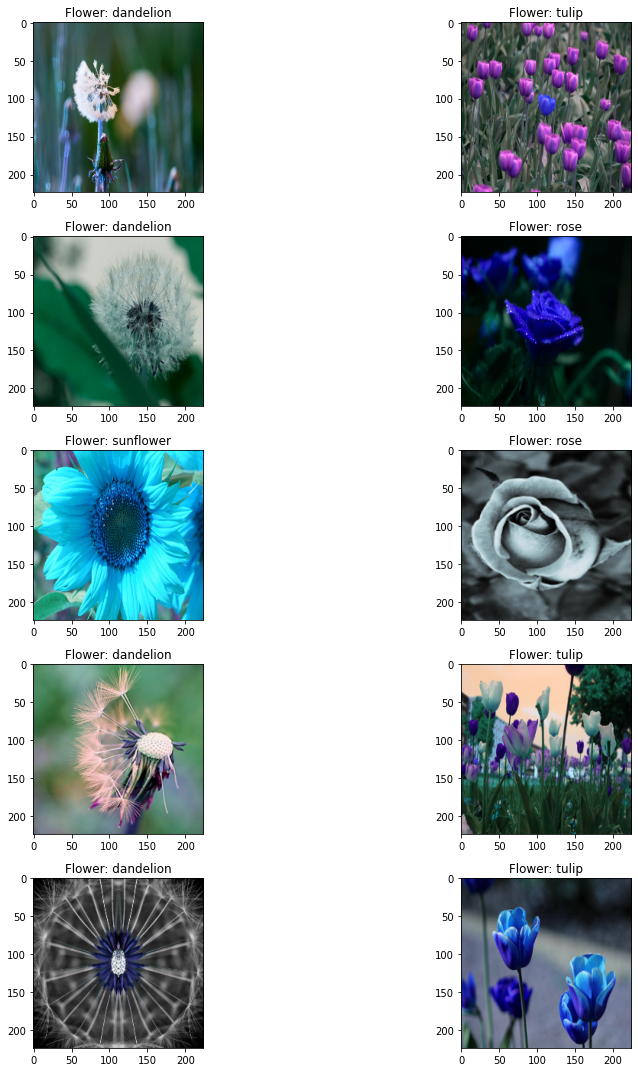

In [4]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=random.randint(0,len(data))
        ax[i,j].imshow(data[l][0])
        ax[i,j].set_title('Flower: '+labels[data[l][1]])
        
plt.tight_layout()

Будем использовать СНС(сверточные нейронные сети).
#CNN
 Это специальная архитектура искусственных нейронных сетей, предложенная Яном Лекуном в 1988 году и нацеленная на эффективное распознавание образов, входит в состав технологий глубокого обучения (англ. deep learning). Использует некоторые особенности зрительной коры, в которой были открыты так называемые простые клетки, реагирующие на прямые линии под разными углами, и сложные клетки, реакция которых связана с активацией определённого набора простых клеток. Таким образом, идея свёрточных нейронных сетей заключается в чередовании свёрточных слоёв (англ. convolution layers) и субдискретизирующих слоёв (англ. subsampling layers или англ. pooling layers, слоёв подвыборки). Структура сети — однонаправленная (без обратных связей), принципиально многослойная. Для обучения используются стандартные методы, чаще всего метод обратного распространения ошибки. Функция активации нейронов (передаточная функция) — любая, по выбору исследователя.

Название архитектура сети получила из-за наличия операции свёртки, суть которой в том, что каждый фрагмент изображения умножается на матрицу (ядро) свёртки поэлементно, а результат суммируется и записывается в аналогичную позицию выходного изображения.

Сверточная нейронная сеть (Convolutional Neural Networks, ConvNet) – класс Нейронных сетей (Neural Network), который специализируется на обработке данных, имеющих топологию в виде сетки, например изображений. Цифровое изображение – это двоичное представление визуальных данных. Он содержит серию пикселей, расположенных в виде сетки, где каждая ячейка содержит визуальные данные: яркость и цвет.

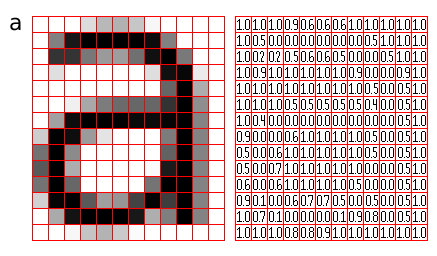

Изображение как сетка пикселей

Архитектура
CNN обычно имеет три уровня: сверточный слой, слой объединения и полностью связанный слой:
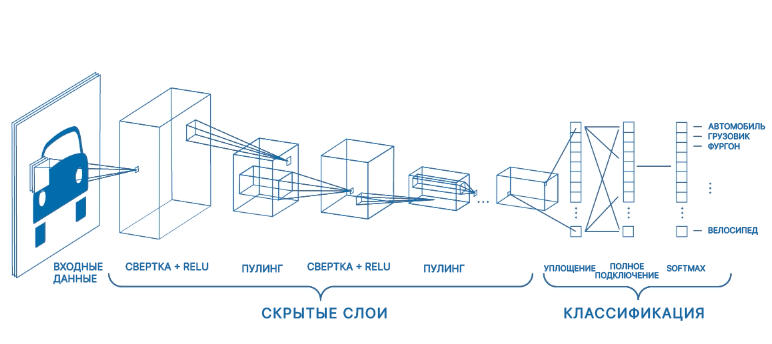

#Сверточный слой
Сверточный слой является основным строительным блоком CNN. Он несет основную часть вычислительной нагрузки сети.

Этот уровень выполняет скалярное произведение между двумя матрицами, где одна матрица представляет собой набор обучаемых параметров, иначе называемых ядром, а другая матрица – ограниченной частью воспринимающего поля. Ядро пространственно меньше изображения, но имеет бо́льшую глубину. Это означает, что если изображение состоит из трех RGB-каналов, высота и ширина ядра будут пространственно малы, но глубина распространяется на все три канала:
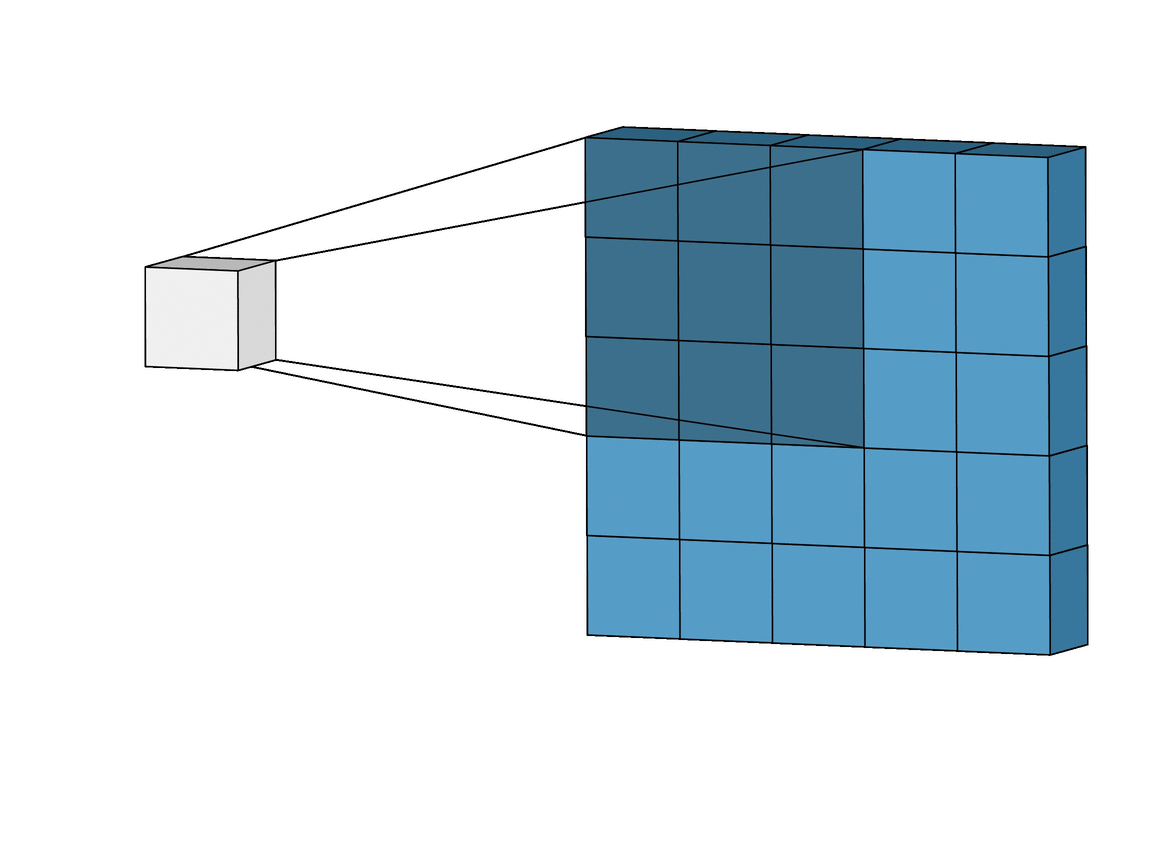

Мы получим выходное разрешение Wout x Wout x Dout.

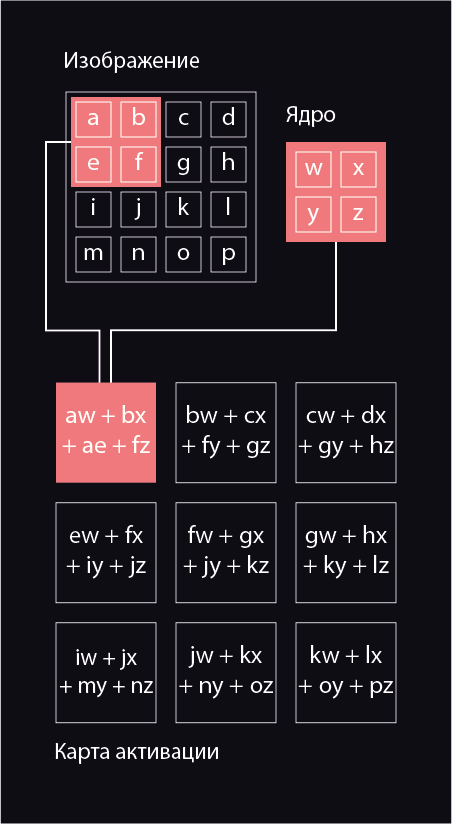

#Слой пулинга
Слой пулинга (объединения) заменяет выходные данные сети в определенных местах, получая сводную статистику ближайших выходов. Это помогает уменьшить пространственный размер представления, что уменьшает необходимое количество вычислений и весов. Операция объединения обрабатывается отдельно для каждого фрагмента представления.

Существует несколько функций объединения, таких как среднее значение прямоугольной окрестности, норма L2 для прямоугольной окрестности и средневзвешенное значение, основанное на расстоянии от центрального пикселя. Однако самый популярный процесс – это максимальный пулинг, которое сообщает о максимальном выходе из окружения.
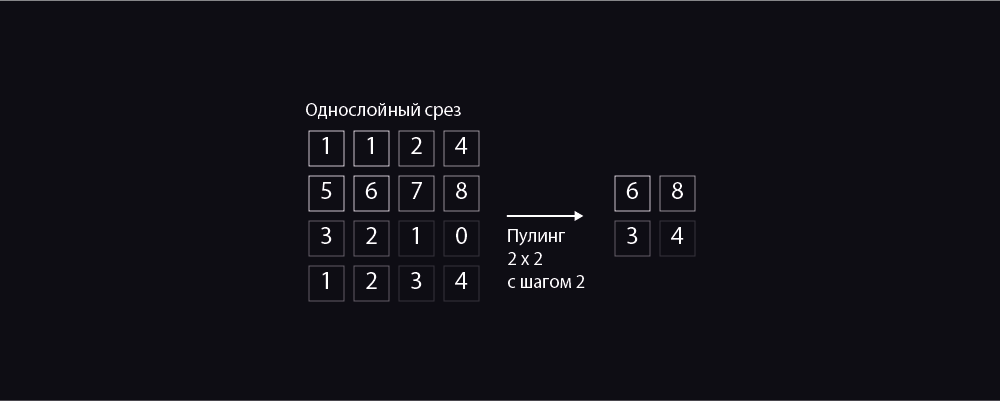

In [5]:
x = []
y = []

for feature, label in data:
    x.append(feature)
    y.append(label)

Обычно в сверточных нейронных сетях используется фугкция активищации Relu,так как она менее ресурсоемкая,чем например гиперполический тангенс,отсекает ненужные детали и не приводит к затуханию или росту градиента.
Выполним нормализацию оттенков серого, чтобы уменьшить влияние различий в освещении, так как СНС сходится быстрее на данных [0..1], чем на [0..255] при Функции активации выпрямителя (ReLU).
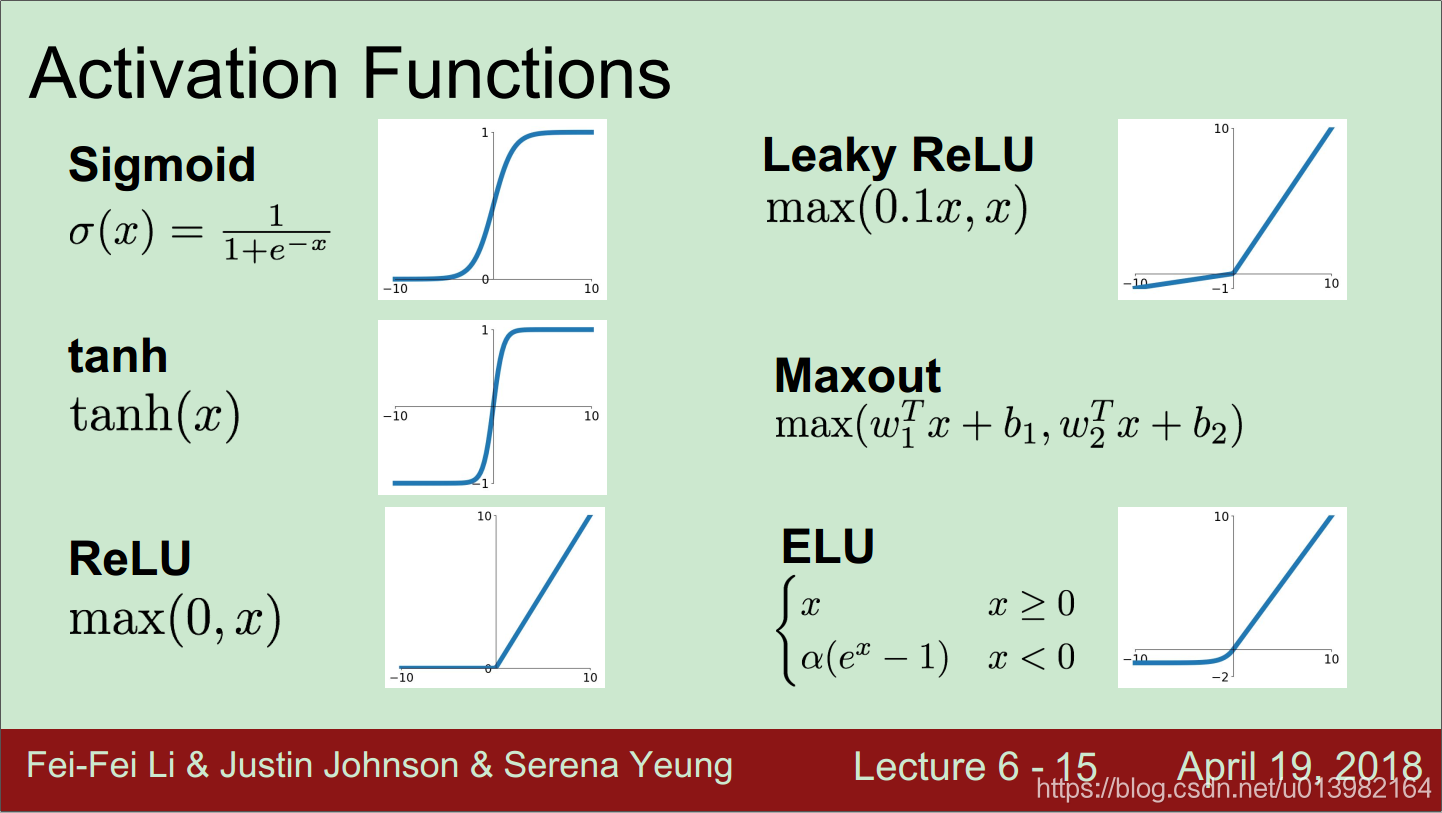


In [6]:
x = np.array(x) / 255

Измененим форму данных с 1-D на 3-D в соответствии с требованиями с помощью ввода CNN's.

In [7]:
x = x.reshape(-1, img_size, img_size, 3)
y = np.array(y)

In [8]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(y)

Разделим выборку на test и train с помощью sklearn

In [9]:
x_train,x_test,y_train,y_test = train_test_split(x , y , test_size = 0.33 , stratify = y , random_state = 0)
del x,y,data # Удалим x,y,data чтобы они не хранились в оперативной памяти TPU(если этого не сделать google collab не потянет такие нагрузки)

#Введение в VGGNet
Полное название VGG - Группа визуальной геометрии, которая принадлежит департаменту науки и техники Оксфордского университета. Компания выпустила серию сверточных сетевых моделей, начиная с VGG, которые могут быть применены для распознавания лиц и классификации изображений, от VGG16 до VGG19. Первоначальная цель исследования VGG глубины сверточных сетей состоит в том, чтобы понять, как глубина сверточных сетей влияет на точность и точность классификации и распознавания крупномасштабных изображений. -Deep-16 CNN), чтобы увеличить количество сетевых уровней и избежать слишком большого количества параметров, во всех слоях используется небольшое ядро свертки 3x3.

#Структура сети
Вход VGG настроен на изображение RGB размером 224x244. Среднее значение RGB вычисляется для всех изображений на изображении обучающего набора, а затем изображение вводится в качестве входных данных в сеть свертки VGG. Используется фильтр 3x3 или 1x1, а шаг свертки фиксирован. . Существует 3 полностью связанных слоя VGG, которые могут варьироваться от VGG11 до VGG 19 в зависимости от общего количества сверточных слоев + полностью связанных слоев. Минимальный VGG11 имеет 8 сверточных слоев и 3 полностью связанных слоя. Максимальный VGG 19 имеет 16 сверточных слоев. +3 полностью соединенных слоя. Кроме того, за сетью VGG не следует объединяющий слой за каждым сверточным слоем, или в общей сложности 5 объединяющих слоев, распределенных под разными сверточными слоями. Следующий рисунок представляет собой структурную схему VGG:

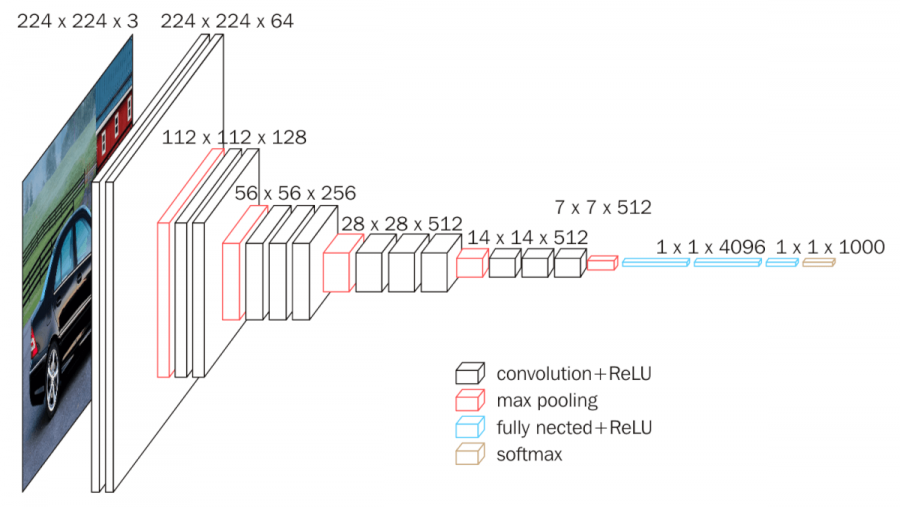

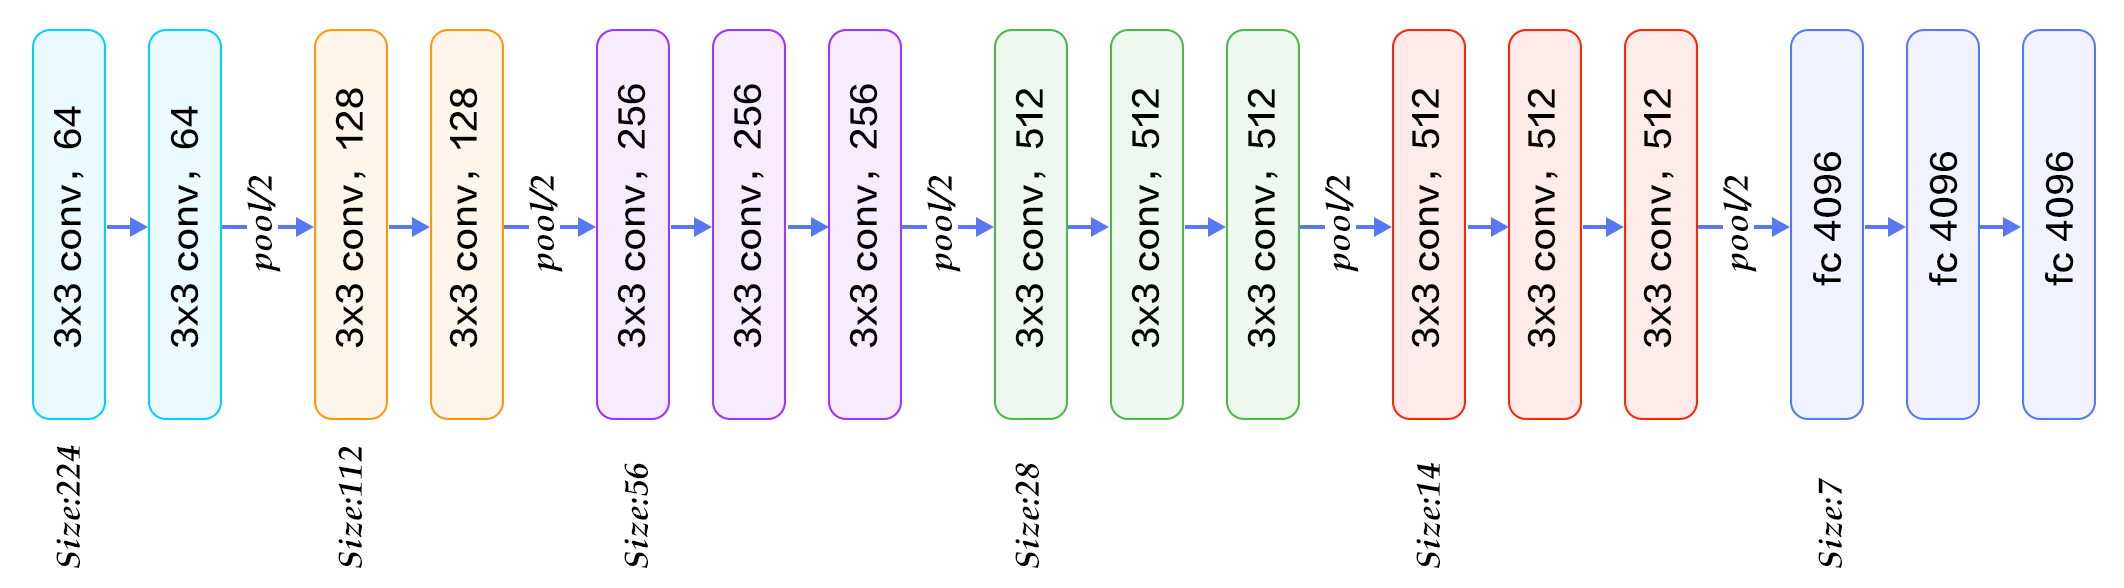

Будем предтренированную модель ImageNet срезая последние полносвязные слои нейронов, отвечающие за финальную классификацию(да, так можно), оставляя только внутренние 4096 нейронов, которые соединяете со своими 2 нейрона для выхода кошка-собака. Получается, что вам нужно будет только дообучить модель этим 2*4096 связям, что делается легко и быстро.

Следующий слой в соответствии с концепцией СНС должен укрупнять масштаб полученных признаков.Чаще всего используется операция MaxPooling.

У нас будет 5 выходов(5 классов цветов),используя классическую функцию активации softmax,которая обеспечит нам способ моделирования сетью вероятностного распределения.
Метод оптимизации выберем adam(выбрал его т.к. он показывает лучший результат,чем SGD).

In [10]:
with strategy.scope(): #используем TPU
    pre_trained_model = VGG19(input_shape=(224,224,3), include_top=False, weights="imagenet")

    for layer in pre_trained_model.layers[:19]:  #обрезаем последний полносвязный слой нейронов
        layer.trainable = False

    model = Sequential([
        pre_trained_model,
        MaxPool2D((2,2) , strides = 2),
        Flatten(),
        Dense(5 , activation='softmax')])
    model.compile(optimizer = "adam" , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 5)                 23045     
                                                                 
Total params: 20,047,429
Trainable params: 4,742,661
Non-trainable params: 15,304,768
_________________________________________________________________


Обучение модели глубокого обучения отнимает много времени. Иногда может случиться так, что вы запускаете модель в течение нескольких дней и не получаете минимальных ожидаемых результатов. Таким образом, мы можем преодолеть это, управляя некоторыми функциями обратного вызова и отслеживая потери, точность и т.д.
Для минимазации данных проблем будем использовать ReduceLROnPlateau: обратный вызов для снижения скорости обучения, когда показатель перестал улучшаться.

In [11]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

Обучим модель выбрав 8 эпох,чтобы не столкнутся с проблемами недообучаемости и переобучаемости(выбрана экспериментально).

In [12]:
history = model.fit(x_train,y_train, batch_size = 64 , epochs = 8 , validation_data = (x_test, y_test),callbacks = [learning_rate_reduction])

Epoch 1/8
46/46 [==============================] - 36s 631ms/step - loss: 0.9213 - accuracy: 0.6528 - val_loss: 0.5654 - val_accuracy: 0.7972 - lr: 0.0010
Epoch 2/8
46/46 [==============================] - 4s 97ms/step - loss: 0.3943 - accuracy: 0.8572 - val_loss: 0.8323 - val_accuracy: 0.7347 - lr: 0.0010
Epoch 3/8
46/46 [==============================] - 4s 93ms/step - loss: 0.3055 - accuracy: 0.8904 - val_loss: 0.4223 - val_accuracy: 0.8554 - lr: 0.0010
Epoch 4/8
46/46 [==============================] - 4s 91ms/step - loss: 0.1356 - accuracy: 0.9523 - val_loss: 0.4774 - val_accuracy: 0.8526 - lr: 0.0010
Epoch 5/8
46/46 [==============================] - 4s 95ms/step - loss: 0.0868 - accuracy: 0.9744 - val_loss: 0.4889 - val_accuracy: 0.8611 - lr: 0.0010
Epoch 6/8
46/46 [==============================] - 4s 92ms/step - loss: 0.0612 - accuracy: 0.9813 - val_loss: 0.6055 - val_accuracy: 0.8365 - lr: 0.0010
Epoch 7/8
45/46 [============================>.] - ETA: 0s - loss: 0.0750 - accu

#Результаты
Проверим на тестовых данных нашу модель.
Accuracy = 86.5%,а это очень хороший результат!

In [13]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

45/45 [==============================] - 6s 36ms/step - loss: 0.5203 - accuracy: 0.8646
Loss of the model is -  0.5202717781066895
45/45 [==============================] - 2s 35ms/step - loss: 0.5203 - accuracy: 0.8646
Accuracy of the model is -  86.45614385604858 %


По графику видно что наша модель слегка(высокая дисперсия значений).
Но 86% это достаточно хороший результат.Чтобы улучшить результат можно поиграться с количеством эпох(что очень ресурсозатратно).Этим самым мы можем получить результат чуть лучшее.
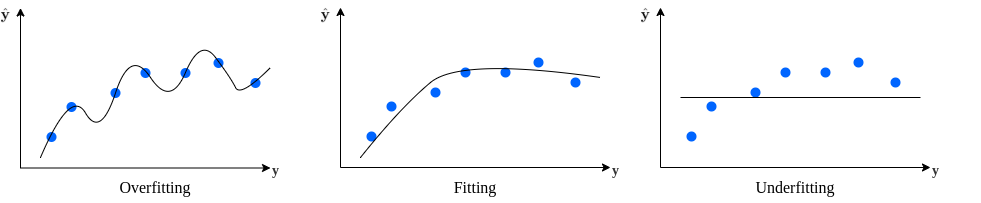

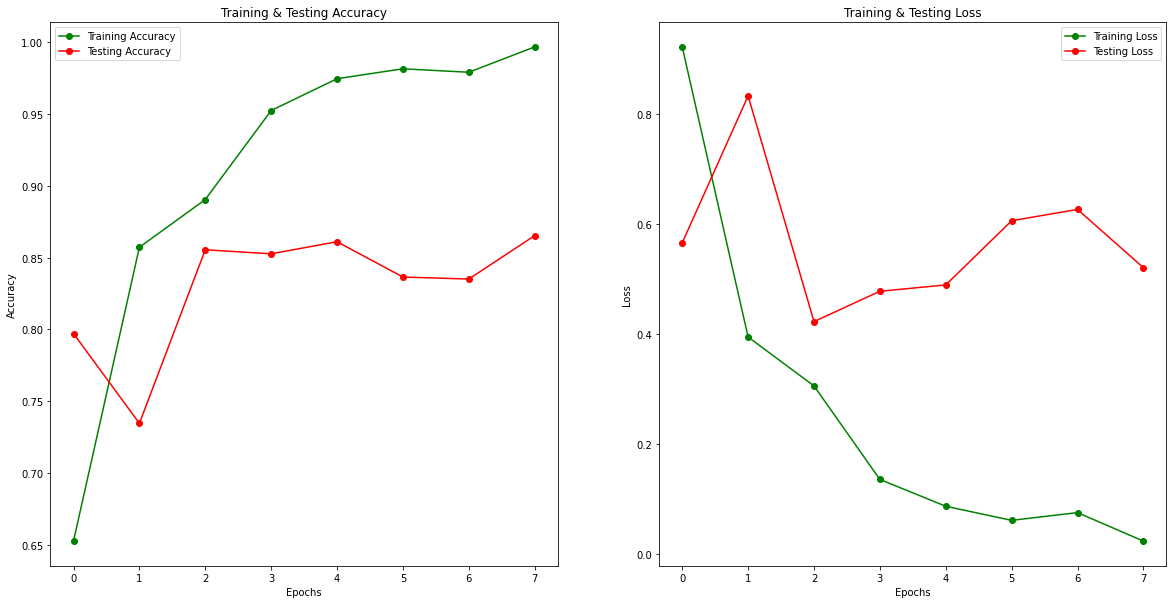

In [14]:
epochs = [i for i in range(8)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()